In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose

from mlxtend.frequent_patterns import apriori, association_rules
import folium



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Replace this path with your own after uploading
df = pd.read_csv('/content/drive/MyDrive/mock_tourism_data.csv')

# Display first few rows
df.head()


,visitor_id,date,country,destination,spend,trip_length,num_visitors,lat,lon
0,V1000,2023-02-19,Brazil,Delhi,963,4,5,46.412300,94.143827
1,V1001,2023-07-20,India,New York,2890,12,1,-87.409172,42.558503
2,V1002,2023-03-16,China,New York,663,1,5,-69.106925,-143.595837
3,V1003,2023-05-23,Brazil,Tokyo,4291,2,3,-81.719524,-149.721550
4,V1004,2023-01-09,Germany,New York,1857,1,4,-82.668816,72.348887


In [4]:
# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Remove rows with missing values (if any)
df = df.dropna()

# Extract month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


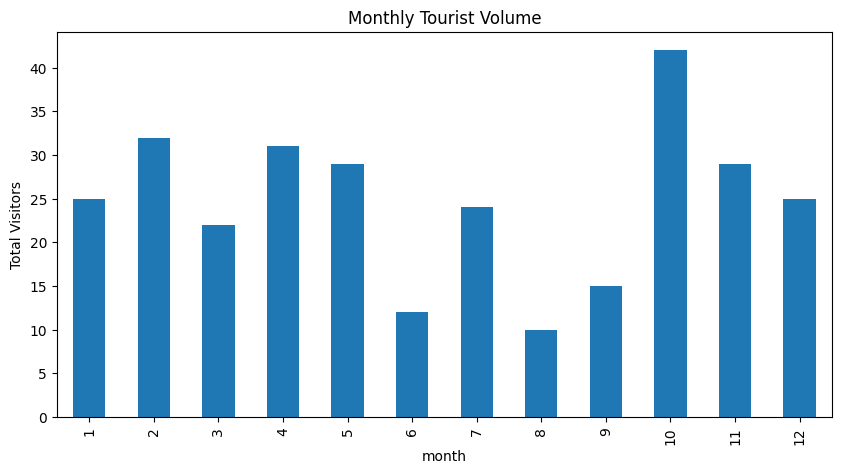

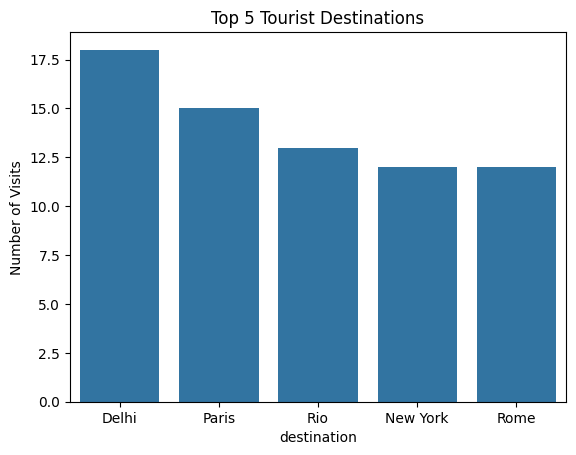

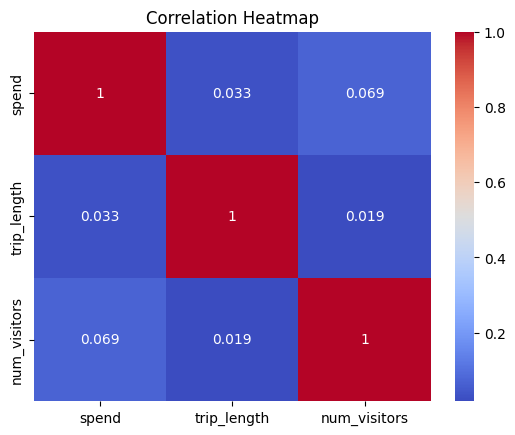

In [5]:
# Monthly Visitors
monthly = df.groupby('month')['num_visitors'].sum()
monthly.plot(kind='bar', title='Monthly Tourist Volume', figsize=(10, 5))
plt.ylabel("Total Visitors")
plt.show()

# Top 5 destinations
top_dest = df['destination'].value_counts().head(5)
sns.barplot(x=top_dest.index, y=top_dest.values)
plt.title("Top 5 Tourist Destinations")
plt.ylabel("Number of Visits")
plt.show()

# Correlation heatmap
sns.heatmap(df[['spend', 'trip_length', 'num_visitors']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


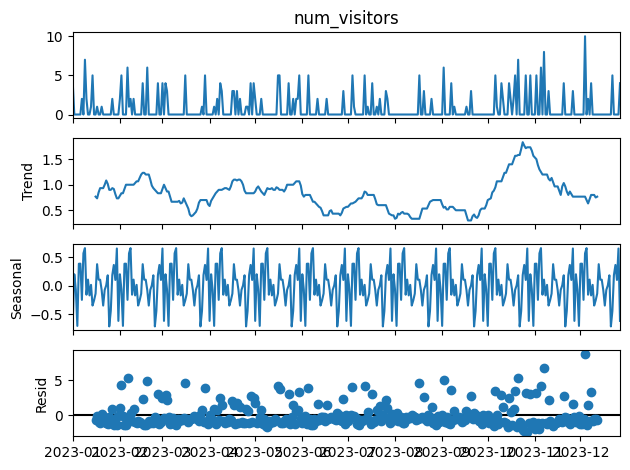

In [6]:
ts = df.groupby('date')['num_visitors'].sum().asfreq('D', fill_value=0)
result = seasonal_decompose(ts, model='additive', period=30)
result.plot()
plt.show()


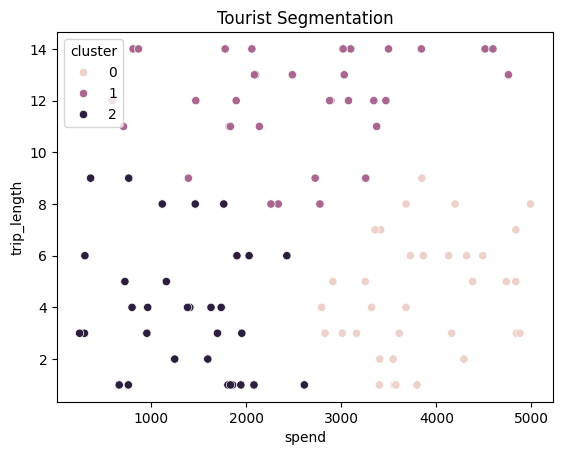

In [7]:
features = df[['spend', 'trip_length']]
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled)

sns.scatterplot(x='spend', y='trip_length', hue='cluster', data=df)
plt.title("Tourist Segmentation")
plt.show()


In [8]:
# Prepare basket format: 1 row per visitor, 1 column per destination
basket = df.groupby(['visitor_id', 'destination'])['destination'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apply Apriori Algorithm
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Display top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


<ipython-input-8-752052cdca70>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift


In [9]:
m = folium.Map(location=[20, 0], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        popup=row['destination'],
        color='blue',
        fill=True
    ).add_to(m)

m


In [10]:
df.to_csv('/content/drive/MyDrive/tourism_analysis_output.csv', index=False)
